In [352]:
import pandas as pd
import datetime
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence
import collections
import seaborn as sns
import pickle as pkl
import shap
from shap import sample

In [353]:
sf = pd.read_csv('ca_san_francisco_2020_04_01.csv')

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.


In [354]:
sf.columns

Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'subject_age', 'subject_race', 'subject_sex', 'type', 'arrest_made',
       'citation_issued', 'warning_issued', 'outcome', 'contraband_found',
       'search_conducted', 'search_vehicle', 'search_basis', 'reason_for_stop',
       'raw_search_vehicle_description', 'raw_result_of_contact_description'],
      dtype='object')

In [383]:
sf_lean = sf.drop(['raw_row_number','date', 'time', 'location', 'lat', 'lng', 'district','type','citation_issued','warning_issued','contraband_found','search_conducted','search_basis','arrest_made','reason_for_stop','raw_search_vehicle_description', 'raw_result_of_contact_description','outcome'],axis=1)

In [384]:
sf_lean.columns

Index(['subject_age', 'subject_race', 'subject_sex', 'search_vehicle'], dtype='object')

In [385]:
# Implement fixed width binning for age

In [386]:
bin_ranges = [0, 18, 35, 45, 60, 75, 100]
bin_names = [1, 2, 3, 4, 5, 6]

In [387]:
sf_lean = sf_lean.dropna(axis=0,inplace=False)

In [388]:
sf_lean.subject_age.astype(int)

33159     56
33160     32
33161     57
33162     31
33163     37
          ..
886037    47
886038    55
886039    36
886040    50
886041    22
Name: subject_age, Length: 846182, dtype: int64

In [389]:
sf_lean['age_bin_custom_range'] = pd.cut(np.array(sf_lean['subject_age']),bins=bin_ranges)
sf_lean['age_bin_custom_label'] = pd.cut(np.array(sf_lean['subject_age']),bins=bin_ranges,labels=bin_names)

In [390]:
sf_lean.subject_age = sf_lean.age_bin_custom_label

In [391]:
# Encode race column

In [392]:
race_encoded = pd.get_dummies(sf_lean.subject_race, drop_first=True)
le = LabelEncoder()
race_encoded = pd.DataFrame(le.fit_transform(sf_lean.subject_race)).astype('category')

In [393]:
sf_lean.subject_race = race_encoded.astype('category')

In [394]:
sf_lean.subject_race.dtype

dtype('float64')

In [395]:
sf_lean.columns

Index(['subject_age', 'subject_race', 'subject_sex', 'search_vehicle',
       'age_bin_custom_range', 'age_bin_custom_label'],
      dtype='object')

In [396]:
sf_lean.subject_sex = pd.get_dummies(sf_lean.subject_sex, drop_first=True)

In [397]:
sf_lean.dropna(inplace=True)

In [413]:
X = sf_lean[['age_bin_custom_label','subject_race','subject_sex']]
y = sf_lean.search_vehicle.dropna()

In [414]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [415]:
log_reg = LogisticRegression(penalty='l1',random_state=42,solver='liblinear',max_iter=1000)

In [416]:
log_reg.fit(X, y)

LogisticRegression(max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [417]:
log_reg.score(X,y)

0.9395097280511157

In [418]:
features = ['subject_race','age_bin_custom_label','subject_sex']

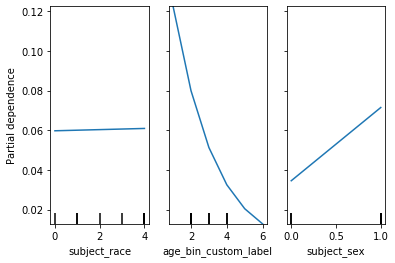

In [419]:
plot_partial_dependence(log_reg, X, features, target=y)

In [420]:
original_variables = list(X_train.columns)
zipped_together = list(zip(original_variables, log_reg.coef_[0]))
coefs = [list(x) for x in zipped_together]
coefs = pd.DataFrame(coefs, columns=["Variable", "Coefficient"])
coefs.sort_values(by=["Coefficient"], axis=0, inplace=True, ascending=False)
coefs

,Variable,Coefficient
2,subject_sex,0.771859
1,subject_race,0.005262
0,age_bin_custom_label,-0.477031


In [421]:
import statsmodels.api as sm

,subject_age,subject_race,subject_sex,search_vehicle,age_bin_custom_range,age_bin_custom_label
33159,4,4.0,1,False,"(45, 60]",4
33160,2,1.0,1,False,"(18, 35]",2
33161,4,4.0,0,False,"(45, 60]",4
33162,2,0.0,1,False,"(18, 35]",2
33163,3,3.0,0,False,"(35, 45]",3
33164,3,3.0,0,False,"(35, 45]",3
33165,2,4.0,1,False,"(18, 35]",2
33166,4,3.0,1,False,"(45, 60]",4
33167,2,4.0,1,False,"(18, 35]",2
33168,3,4.0,1,False,"(35, 45]",3


In [409]:
X = np.array(X)
y = np.array(y)

In [423]:
X = sf_lean[['age_bin_custom_label','subject_race','subject_sex']]
y = sf_lean.search_vehicle

In [425]:
res = sm.Logit(y, X.astype(float)).fit()

Optimization terminated successfully.
         Current function value: 0.228117
         Iterations 8


In [426]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         search_vehicle   No. Observations:               806328
Model:                          Logit   Df Residuals:                   806325
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Jun 2020   Pseudo R-squ.:               0.0008663
Time:                        19:49:43   Log-Likelihood:            -1.8394e+05
converged:                       True   LL-Null:                   -1.8410e+05
Covariance Type:            nonrobust   LLR p-value:                 5.452e-70
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
age_bin_custom_label    -1.0223      0.004   -253.123      0.000      -1.030      -1.014
subject_race            -0.1114      0.003    -41.686      0.000      -0.117      -0.106
subject_sex              0.2196      0.009     23.203      0.000       0.201       0.238
========================================================================================
"""

In [427]:
np.exp(res.params)

age_bin_custom_label    0.359757
subject_race            0.894602
subject_sex             1.245579
dtype: float64